2024-05-11 01:34:11.543725: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-11 01:34:11.547390: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-11 01:34:11.587226: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 01:34:12.338811: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Classification Accuracies:
Activation FunctionLearning Rate Train Accuracy(%) Validation Accuracy(%) Test Accuracy(%)
tanh            0.001           100.00          100.00              100.00         
tanh            0.01            100.00          100.00              100.00         
tanh            0.015           100.00          100.00              100.00         
tanh            0.02            100.00          100.00              100.00         
tanh            0.03            100.00          100.00              100.00         
sigmoid         0.001           100.00          100.00              100.00         
sigmoid         0.01            100.00          100.00              100.00         
sigmoid         0.015           100.00          100.00              100.00         
sigmoid         0.02            100.00          100.00              100.00         
sigmoid         0.03            100.00          100.00              100.00         
relu            0.001           99.72     

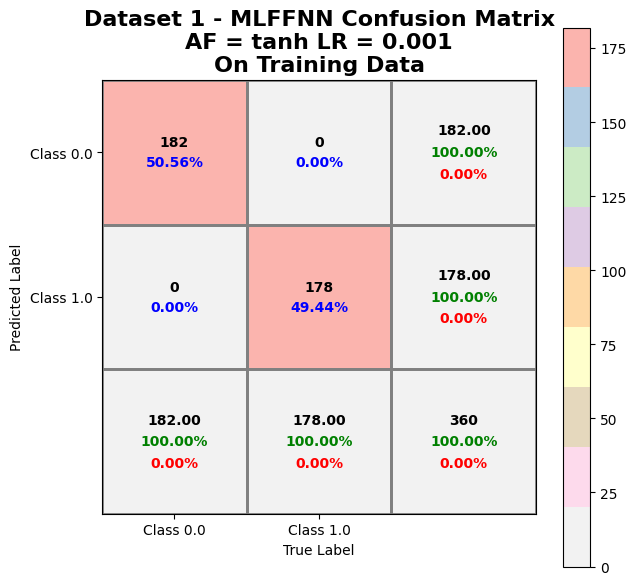

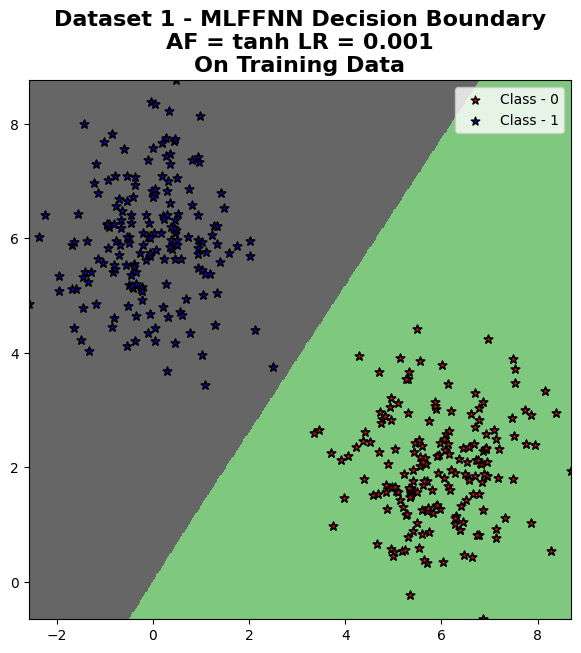

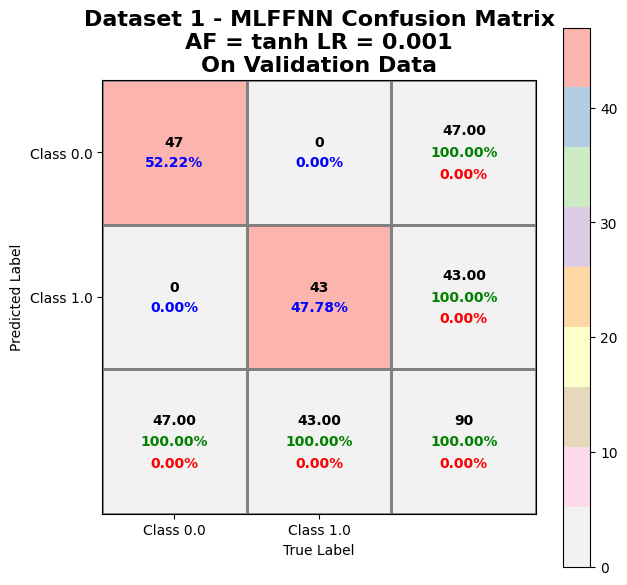

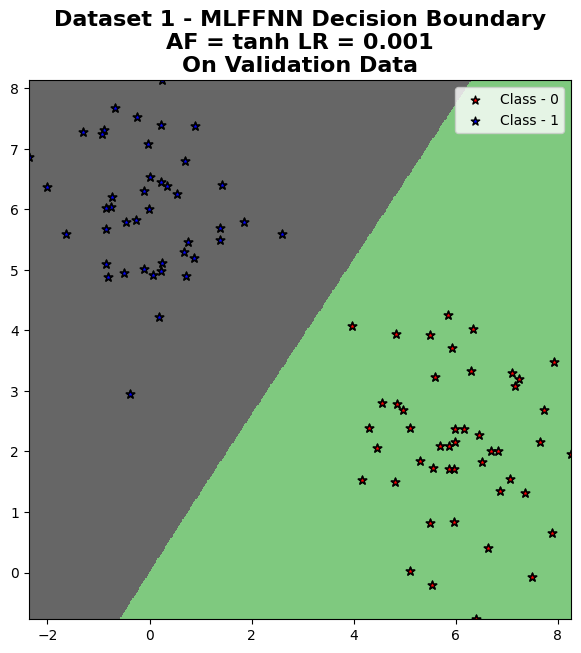

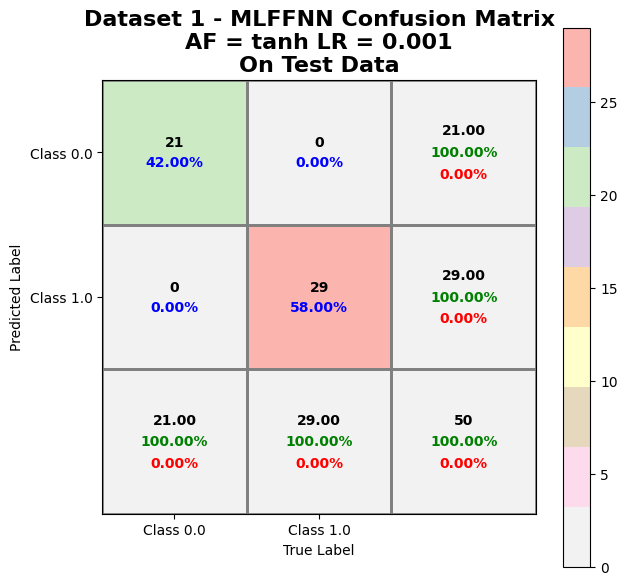

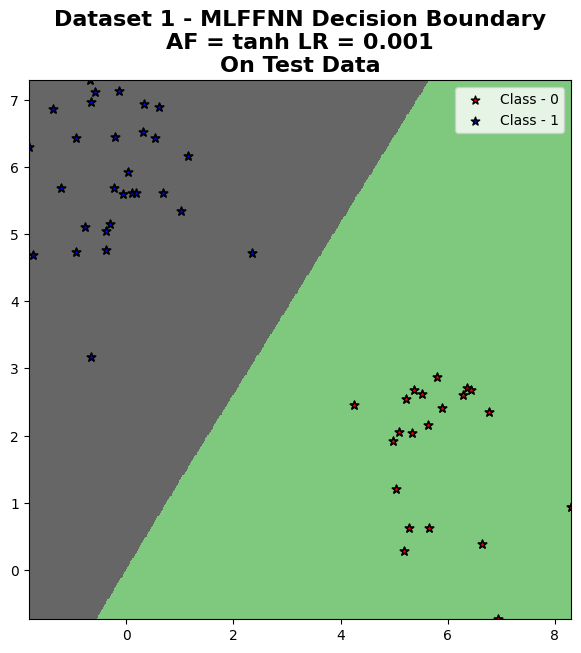

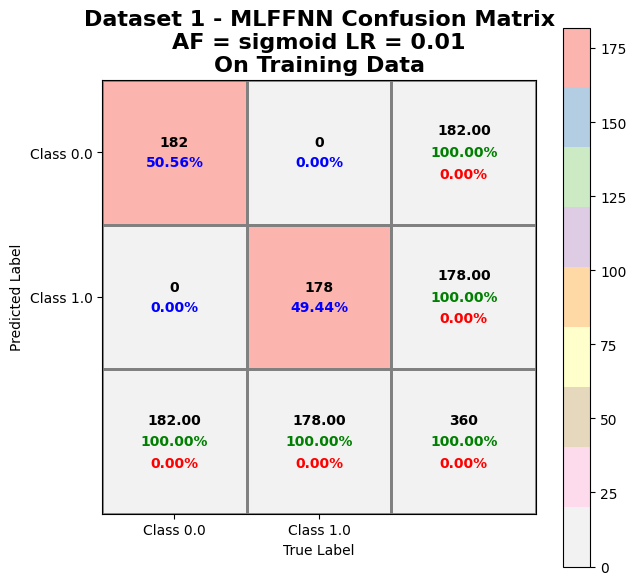

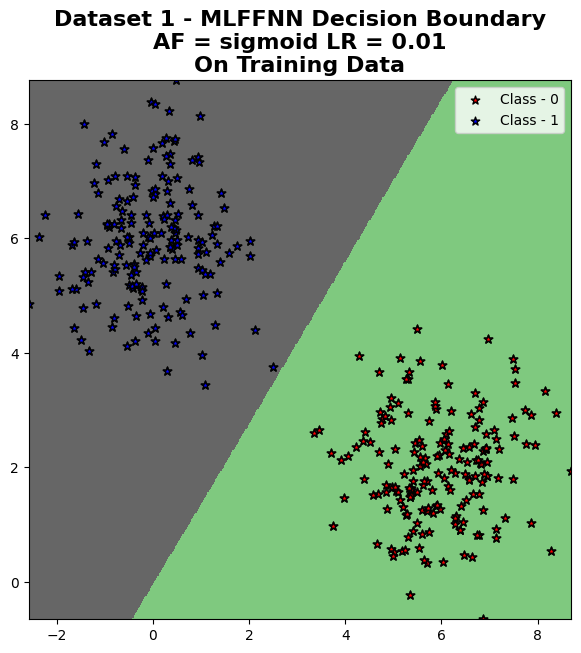

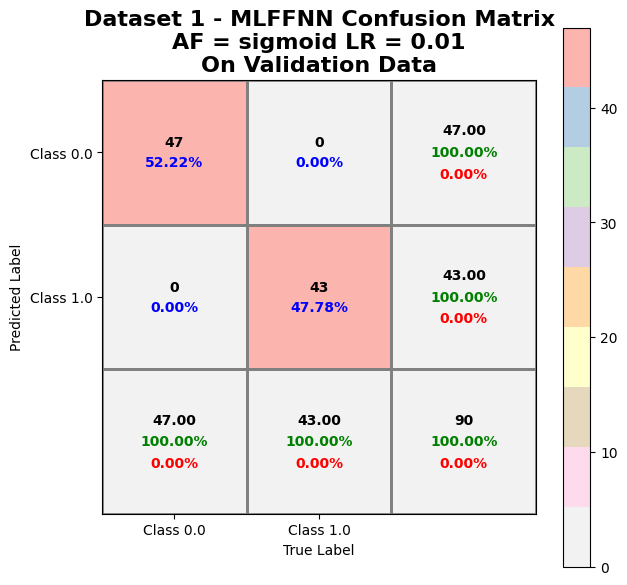

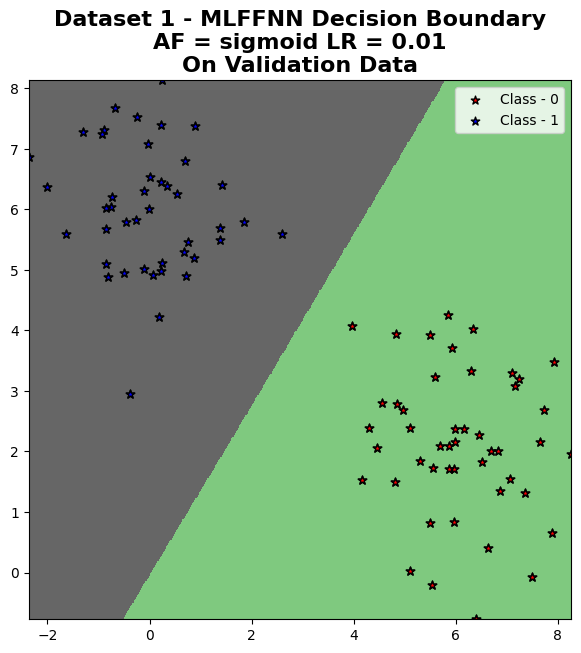

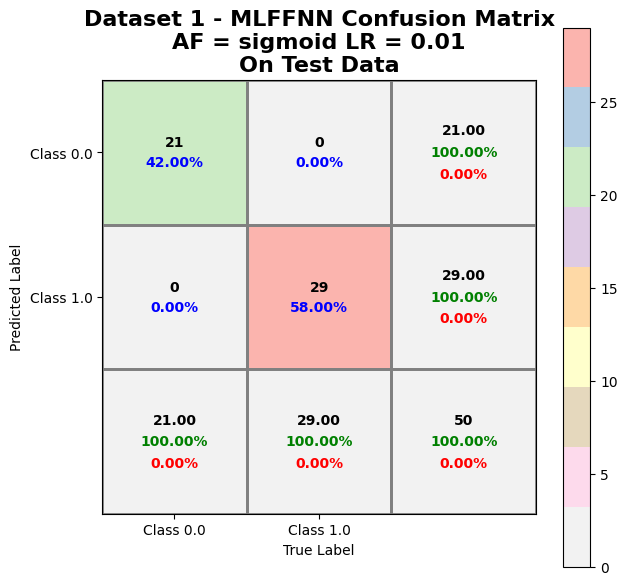

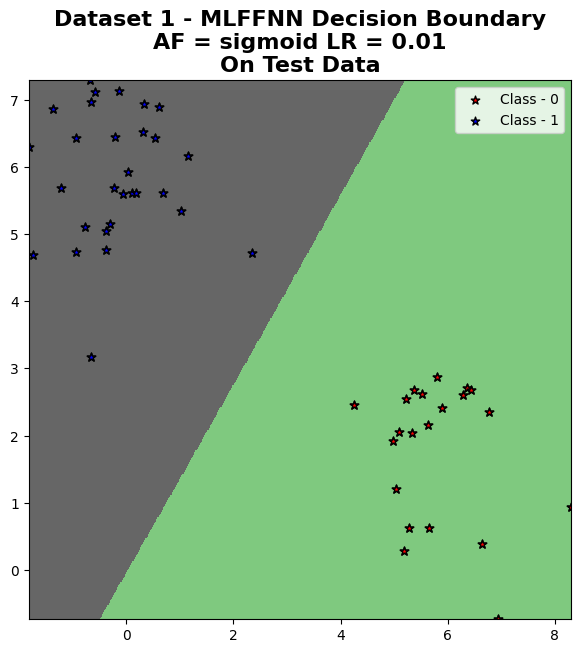

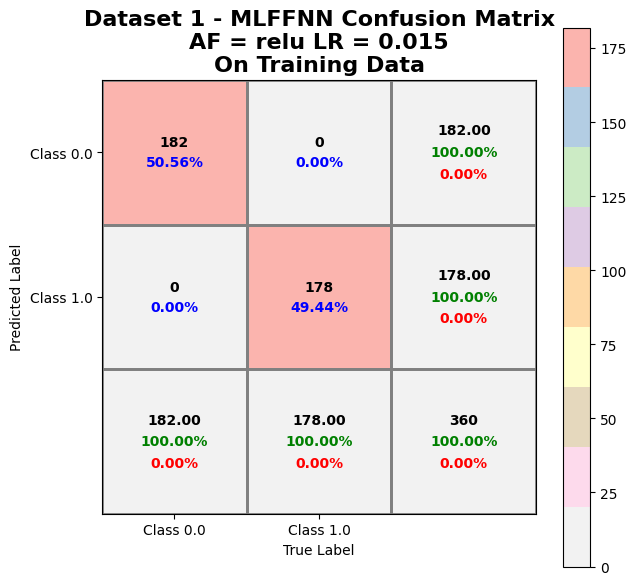

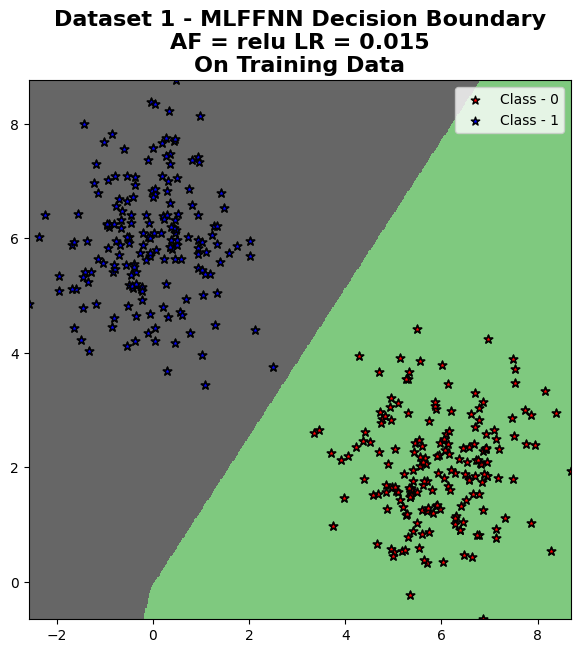

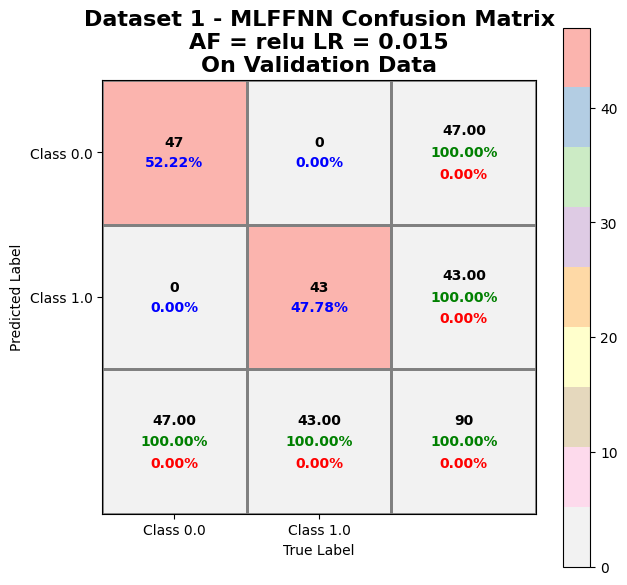

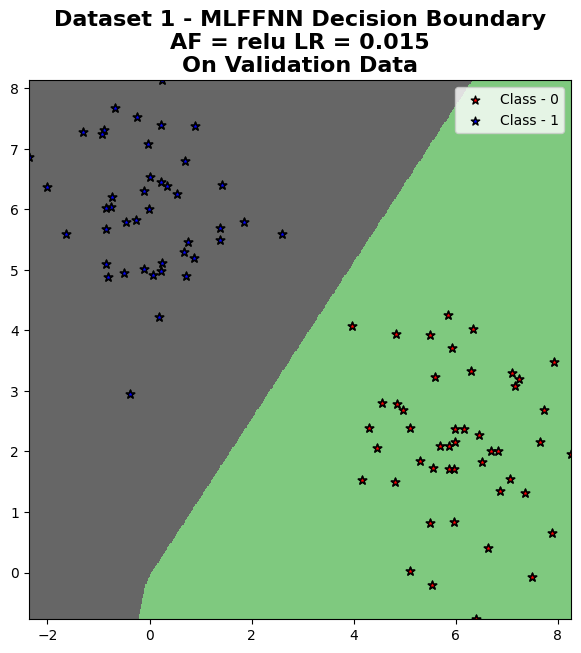

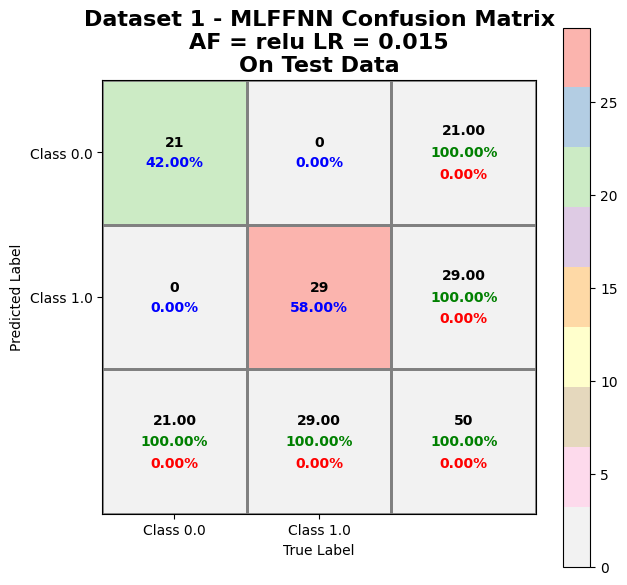

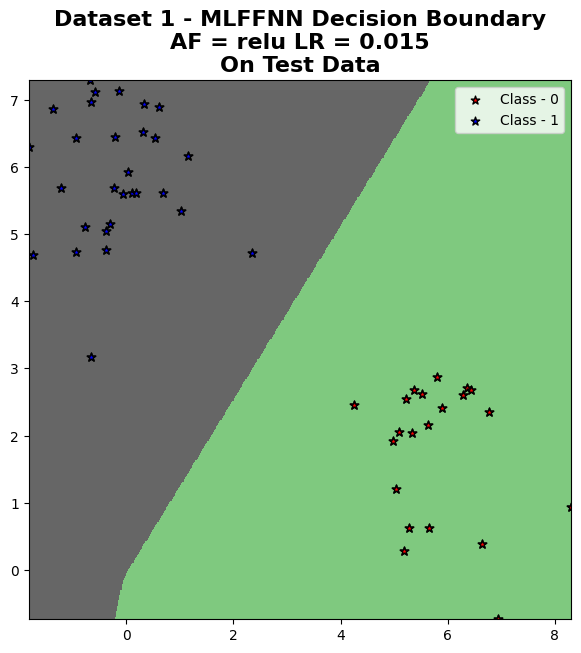

In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf


# Function to build and train the model
def build_and_train_model(train_x, train_y, learning_rate, activation_function):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Build the model
        model = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(
                    64, activation=activation_function, input_shape=(2,)
                ),
                tf.keras.layers.Dense(2, activation="softmax"),
            ]
        )

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Train the model
    history = model.fit(train_x, train_y, epochs=50, batch_size=32, verbose=0)

    return model, history


# Function to calculate classification accuracy and confusion matrix
def evaluate_model(model, x, y):
    # Predictions
    y_pred = np.argmax(model.predict(x, verbose=0), axis=1)

    # Classification accuracy
    accuracy = np.mean(y_pred == y) * 100

    return accuracy, y_pred


def confusion_matrix(y_true, y_pred, accuracy, labels=None):
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
    num_labels = len(labels)
    cm = np.zeros((num_labels + 1, num_labels + 1), float)
    label_to_index = {label: i for i, label in enumerate(labels)}
    true_positives = np.zeros(num_labels)
    pred_positives = np.zeros(num_labels)
    total_samples = len(y_true)
    for true, pred in zip(y_true, y_pred):
        true_index = label_to_index[true]
        pred_index = label_to_index[pred]
        cm[true_index, pred_index] += 1
        true_positives[true_index] += 1 if true == pred else 0
        pred_positives[pred_index] += 1 if true == pred else 0
    cm = cm.T
    accuracy = np.sum(np.diag(cm)) / total_samples
    cm[-1, :-1] = (true_positives / np.sum(cm[:-1, :-1], axis=1)) * 100
    cm[:-1, -1] = (pred_positives / np.sum(cm[:-1, :-1], axis=0)) * 100
    cm[-1, -1] = accuracy * 100
    return cm


# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, accuracy, title):
    cm = confusion_matrix(y_true, y_pred, accuracy)
    cm_backup = confusion_matrix(y_true, y_pred, accuracy)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == cm.shape[0] - 1 or j == cm.shape[1] - 1:
                cm[i, j] = 0.0
    number_of_classes = len(np.unique(y_true))
    plt.figure(figsize=(number_of_classes + 5, number_of_classes + 5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Pastel1_r)
    cm = cm_backup
    plt.title(title, fontsize=16, weight="bold")
    plt.colorbar()
    labels = []
    for i in np.unique(y_true):
        label = "Class " + str(i)
        labels.append(label)
    plt.xticks(range(len(np.unique(y_true))), labels=labels)
    plt.yticks(range(len(np.unique(y_true))), labels=labels)
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")

    cm_except_last_row_col = cm[:-1, :-1]
    cm_row_sum = np.sum(cm_except_last_row_col, axis=1)
    cm_col_sum = np.sum(cm_except_last_row_col, axis=0)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        row_sum = 0
        for j in range(cm.shape[1]):
            if i == cm.shape[0] - 1 and j == cm.shape[1] - 1:
                plt.text(
                    j,
                    i - 0.15,
                    format(y_true.size, "d"),
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="black",
                )
                plt.text(
                    j,
                    i,
                    format(cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="green",
                )
                plt.text(
                    j,
                    i + 0.15,
                    format(100 - cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="red",
                )
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="grey", linewidth=2
                )
                plt.gca().add_patch(rect)
            elif j == cm.shape[1] - 1:
                plt.text(
                    j,
                    i - 0.15,
                    format(cm_row_sum[i], ".2f"),
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="black",
                )
                plt.text(
                    j,
                    i,
                    format(cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="green",
                )
                plt.text(
                    j,
                    i + 0.15,
                    format(100 - cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="red",
                )
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="grey", linewidth=2
                )
                plt.gca().add_patch(rect)
            elif i == cm.shape[0] - 1:
                plt.text(
                    j,
                    i - 0.15,
                    format(cm_col_sum[j], ".2f"),
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="black",
                )
                plt.text(
                    j,
                    i,
                    format(cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="green",
                )
                plt.text(
                    j,
                    i + 0.15,
                    format(100 - cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="red",
                )
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="grey", linewidth=2
                )
                plt.gca().add_patch(rect)
            else:
                percent = (cm[i, j] / y_true.size) * 100
                plt.text(
                    j,
                    i - 0.07,
                    format(int(cm[i, j]), "d"),
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="black",
                )
                plt.text(
                    j,
                    i + 0.07,
                    format(percent, ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="blue",
                )
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="grey", linewidth=2
                )
                plt.gca().add_patch(rect)

    plt.grid(False)
    # plt.savefig("/home/dipendu/programs/mtech_2023/ml/ass2/trial/cls_1/"+plot_title+'.png')
    plt.show()


def plot_decision_boundary(model, x, y, title):
    N = 500

    # Create a meshgrid to plot decision regions
    x_min, x_max = x[:, 0].min(), x[:, 0].max()
    y_min, y_max = x[:, 1].min(), x[:, 1].max()
    x_range = np.linspace(x_min, x_max, N)
    y_range = np.linspace(y_min, y_max, N)
    xx, yy = np.meshgrid(x_range, y_range)

    Z = np.argmax(model.predict(np.c_[xx.ravel(), yy.ravel()], verbose=0), axis=1)
    Z = Z.reshape(xx.shape)

    # Plot decision regions
    classes = np.unique(y)
    number_of_classes = len(classes)
    plt.figure(figsize=(number_of_classes + 5, number_of_classes + 5))
    plt.pcolormesh(xx, yy, Z, cmap="Accent")
    for class_label in classes:
        # Filter data points based on the current label
        x_label = x[y == class_label]
        # Plot only once with the label
        if class_label == classes[0]:
            plt.scatter(
                x_label[:, 0],
                x_label[:, 1],
                c="red",
                edgecolors="black",
                marker="*",
                s=40,
                label="Class - " + str(int(class_label)),
            )
            # plt.legend()
        else:
            plt.scatter(
                x_label[:, 0],
                x_label[:, 1],
                c="blue",
                edgecolors="black",
                marker="*",
                s=40,
            )
        if class_label == classes[1]:
            plt.scatter(
                x_label[:, 0],
                x_label[:, 1],
                c="blue",
                edgecolors="black",
                marker="*",
                s=40,
                label="Class - " + str(int(class_label)),
            )
            # plt.legend()
        else:
            plt.scatter(
                x_label[:, 0],
                x_label[:, 1],
                c="red",
                edgecolors="black",
                marker="*",
                s=40,
            )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.legend()

    # plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    # plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(title, fontsize=16, weight="bold")
    # plt.savefig("/home/dipendu/programs/mtech_2023/ml/ass2/trial/cls_1/"+plot_title+'.png')
    plt.show()


def read_dataset_1(current_directory, folder_number):
    # classification_dataset_1_path=current_directory+ "/Datasets_for_A1/Classification/Dataset 1/" + folder_number + "/"
    classification_dataset_1_path = (
        "/home/dipendu/programs/mtech_2023/ml/ass2/Datasets_for_A1/Classification/Dataset 1/"
        + folder_number
        + "/"
    )

    classification_dataset_1_Train = (
        classification_dataset_1_path + "Train-" + folder_number + ".csv"
    )
    df = pd.read_csv(classification_dataset_1_Train)
    data = df.to_numpy()
    train_x = data[:, 1:3]
    train_y = data[:, 3]

    classification_dataset_1_Validation = (
        classification_dataset_1_path + "Val-" + folder_number + ".csv"
    )
    df = pd.read_csv(classification_dataset_1_Validation)
    data = df.to_numpy()
    val_x = data[:, 1:3]
    val_y = data[:, 3]

    classification_dataset_1_Test = (
        classification_dataset_1_path + "Test-" + folder_number + ".csv"
    )
    df = pd.read_csv(classification_dataset_1_Test)
    data = df.to_numpy()
    test_x = data[:, 1:3]
    test_y = data[:, 3]

    return train_x, train_y, val_x, val_y, test_x, test_y


def apply_MLFFNN(train_x, train_y, val_x, val_y, test_x, test_y):
    # Define hyperparameters
    learning_rates = [0.001, 0.01, 0.015, 0.02, 0.03]  # Different learning rates
    activation_functions = ["tanh", "sigmoid", "relu"]

    # Dictionary to store results
    results = {}
    models = {}
    histories = {}
    # Loop over different hyperparameters
    for activation_function in activation_functions:
        for learning_rate in learning_rates:
            # Build and train the model
            model, history = build_and_train_model(
                train_x, train_y, learning_rate, activation_function
            )
            models[(activation_function, learning_rate)] = model
            histories[(activation_function, learning_rate)] = history

            # Evaluate the model on training data
            train_accuracy, train_y_pred = evaluate_model(model, train_x, train_y)

            # Evaluate the model on validation data
            val_accuracy, val_y_pred = evaluate_model(model, val_x, val_y)

            # Evaluate the model on test data
            test_accuracy, test_y_pred = evaluate_model(model, test_x, test_y)

            # Store results
            results[(activation_function, learning_rate)] = {
                "train_accuracy": train_accuracy,
                "val_accuracy": val_accuracy,
                "test_accuracy": test_accuracy,
                "train_y_pred": train_y_pred,
                "val_y_pred": val_y_pred,
                "test_y_pred": test_y_pred,
            }

    # Print the table of classification accuracies
    print("Classification Accuracies:")
    print(
        "{:<15} {:<15} {:<15} {:<15}".format(
            "Activation Function" "Learning Rate",
            "Train Accuracy(%)",
            "Validation Accuracy(%)",
            "Test Accuracy(%)",
        )
    )
    for key, result in results.items():
        activation_function, learning_rate = key
        print(
            "{:<15} {:<15} {:<15.2f} {:<19.2f} {:<15.2f}".format(
                activation_function,
                learning_rate,
                result["train_accuracy"],
                result["val_accuracy"],
                result["test_accuracy"],
            )
        )

    # Plot confusion matrices and descision boundary
    title = "Dataset 1 - MLFFNN"
    cm = " Confusion Matrix\nAF = "
    db = " Decision Boundary\nAF = "
    for activation_function, learning_rate in zip(activation_functions, learning_rates):
        result = results[(activation_function, learning_rate)]
        model = models[(activation_function, learning_rate)]

        td = "\nOn Training Data"
        plot_confusion_matrix(
            train_y,
            result["train_y_pred"],
            result["train_accuracy"],
            title + cm + activation_function + " LR = " + str(learning_rate) + td,
        )
        plot_decision_boundary(
            model,
            train_x,
            train_y,
            title + db + activation_function + " LR = " + str(learning_rate) + td,
        )

        td = "\nOn Validation Data"
        plot_confusion_matrix(
            val_y,
            result["val_y_pred"],
            result["val_accuracy"],
            title + cm + activation_function + " LR = " + str(learning_rate) + td,
        )
        plot_decision_boundary(
            model,
            val_x,
            val_y,
            title + db + activation_function + " LR = " + str(learning_rate) + td,
        )

        td = "\nOn Test Data"
        plot_confusion_matrix(
            test_y,
            result["test_y_pred"],
            result["test_accuracy"],
            title + cm + activation_function + " LR = " + str(learning_rate) + td,
        )
        plot_decision_boundary(
            model,
            test_x,
            test_y,
            title + db + activation_function + " LR = " + str(learning_rate) + td,
        )


def main():
    folder_number = "9"
    current_directory = os.getcwd()

    train_x, train_y, val_x, val_y, test_x, test_y = read_dataset_1(
        current_directory, folder_number
    )
    apply_MLFFNN(train_x, train_y, val_x, val_y, test_x, test_y)


if __name__ == "__main__":
    main()